In [1]:
%matplotlib inline

import pandas as pd
import datetime
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import statistics
from scipy import signal
import random
import uuid
import json

In [2]:
#Model parameters
num_machines = 10
num_prod_lines = 5
cyclical_maintenance = 30 #number of days

fault_prob = [0.001, 0.003, 0.005]

#To be decided if the numbers are per day or per hour
scenarios = {
    "normal":
    {
        "avg_yield": 1500,
        "std_yield": 5,
        "avg_perc_defects": 0.01,
        "std_perc_defects": 0.001,
        "avg_energy_cons": 10000,
        "std_energy_cons": 200
    },
    "abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 10,
        "avg_perc_defects": 0.03,
        "std_perc_defects": 0.003,
        "avg_energy_cons": 20000,
        "std_energy_cons": 500,
    },
    "highly_abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 20,
        "avg_perc_defects": 0.05,
        "std_perc_defects": 0.005,
        "avg_energy_cons": 30000,
        "std_energy_cons": 500,
    }
}

In [3]:
def gaussian_distr(mean, std, size):
    return np.random.normal(loc=mean, scale=std, size=size)

def possoin_distr(prob, size):
    return np.random.poisson(lam=prob, size=size)

a = gaussian_distr(scenarios["normal"]["avg_yield"], scenarios["normal"]["std_yield"], 10000)
b = gaussian_distr(scenarios["normal"]["avg_perc_defects"], scenarios["normal"]["std_perc_defects"], 10000)
#print(a)

In [4]:
def plot_hist(data, step, title):
    fig, ax = plt.subplots()
    #plt.xlabel("a")
    #plt.ylabel(r"b")
    ax.grid()
    plt.hist(data, bins=np.arange(data.min(), data.max(), step))
    plt.title(title)
    plt.show();

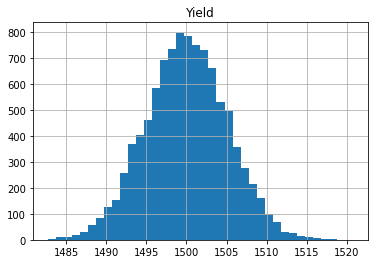

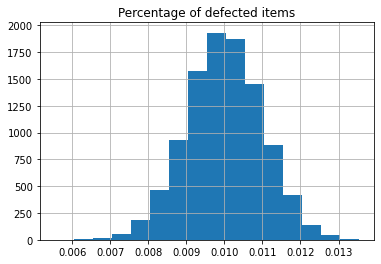

In [5]:
plot_hist(a, 1, "Yield")
plot_hist(b, 0.0005, "Percentage of defected items")

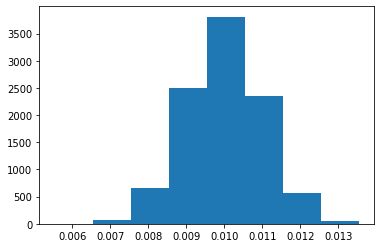

In [6]:
#plt.hist(a, bins=np.arange(a.min(), a.max()+1, 1))
plt.hist(b, bins=np.arange(b.min(), b.max(), 0.001))
plt.show()

In [7]:
def next_maint(data, df, list_maint):
    output = None
    #print(data)
    #print(list_maint)
    for x, y in zip(list_maint, list_maint[1:]):
        #print(x, y)
        if(data >= x and data <= y):
            output=df.iloc[y]['Timestamp']
            #print(y, output)
    return output

In [8]:
def generateTimeSeries(months):
    
    date_rng = pd.date_range(start=datetime.date.today() - datetime.timedelta(months*365/12), 
                             end=datetime.date.today(), freq='H')
    df = pd.DataFrame(date_rng, columns=['Timestamp'])
    
    df['year'] = df.Timestamp.dt.year
    df['month'] = df.Timestamp.dt.month
    df['day'] = df.Timestamp.dt.day
    df['index'] = df.Timestamp.index
    
    df['CycMaintenance'] = 0
    df.loc[(df.Timestamp.dt.day%28 == 0) & (df.Timestamp.dt.hour%13 == 0) & 
           (df.Timestamp.dt.hour != 0), 'CycMaintenance'] = 1
    #print(df[df['CycMaintenance'] == 1])
    
    list_maint = df[df.CycMaintenance == 1].index.tolist()
    list_maint.append(df.index.min())
    list_maint.append(df.index.max())
    list_maint.sort()
    print(list_maint)
    
    df['NextMaintenance'] = df['index'].apply(next_maint, args=(df, list_maint))

    df1 = pd.DataFrame(range(1, num_machines+1), columns=['MachineID'])
    df2 = pd.DataFrame(range(1, num_prod_lines+1), columns=['ProdLineID'])

    df_tot = df2.merge(df1, how='cross')
    df_tot['FaultProb'] = random.choices(fault_prob, k = len(df_tot))
    df_tot = df.merge(df_tot, how='cross')
    
    df_tot['EnergyCons'] = gaussian_distr(scenarios["normal"]["avg_energy_cons"], 
                                          scenarios["normal"]["std_energy_cons"], len(df_tot))
    
    df_tot['Yield'] = gaussian_distr(scenarios["normal"]["avg_yield"], 
                                          scenarios["normal"]["std_yield"], len(df_tot))
    
    df_tot['DefectedItems'] = df_tot['Yield']*gaussian_distr(scenarios["normal"]["avg_perc_defects"], 
                                          scenarios["normal"]["std_perc_defects"], len(df_tot))
    
    
    return df_tot

In [9]:
df = generateTimeSeries(3)

[0, 685, 1429, 2173, 2184]


In [10]:
#print(df['ProdLineID'].unique())
df['Fault'] = 0

for i in df['ProdLineID'].unique():
    #print(i)
    for j in df['MachineID'].unique():
        #print(str(i)+", "+str(j))
        #print(df[(df.ProdLineID == i) & (df.MachineID == j)]['FaultProb'].unique())
        temp = (df[(df.ProdLineID == i) & (df.MachineID == j)]).copy()
        temp = temp[['FaultProb','Fault']]
        #print(len(temp))
        temp['Fault'] = possoin_distr(temp['FaultProb'].unique(), len(temp))
        df.loc[temp.index , 'Fault'] = temp['Fault']

#print(df)

In [11]:
#print(list(scenarios.keys())[1:])
#print(random.choices(list(scenarios.keys())[1:], k = len(df[df.Fault == 1])))
df['FaultType'] = 'normal'
df.loc[df.Fault == 1, 'FaultType'] = random.choices(list(scenarios.keys())[1:2], k = len(df[df.Fault == 1]))

In [12]:
print(df[(df.ProdLineID == 1) & (df.MachineID == 1) & (df.Fault == 1)])
df_fault = df[df.Fault == 1]

                Timestamp  year  month  day  index  CycMaintenance  \
68350 2022-01-25 23:00:00  2022      1   25   1367               0   
76950 2022-02-02 03:00:00  2022      2    2   1539               0   
80500 2022-02-05 02:00:00  2022      2    5   1610               0   

          NextMaintenance  ProdLineID  MachineID  FaultProb    EnergyCons  \
68350 2022-01-28 13:00:00           1          1      0.001  10209.954527   
76950 2022-02-28 13:00:00           1          1      0.001   9905.596550   
80500 2022-02-28 13:00:00           1          1      0.001   9954.025448   

             Yield  DefectedItems  Fault FaultType  
68350  1503.679202      15.345134      1  abnormal  
76950  1491.717185      15.911582      1  abnormal  
80500  1504.996380      15.681149      1  abnormal  


In [ ]:
import itertools

from pandarallel import pandarallel
pandarallel.initialize()

def spalma(data, temp, i, j):
    output = 0
    temp1 = temp[temp.Fault == 1]
    #print(data)
    for index, row in temp1.iterrows():
        #print(data,row['Timestamp'],row['NextMaintenance'])
        if((data >= row['Timestamp']) & (data < row['NextMaintenance'])):
            output = 1
    # print(output)
    return output

temp_list = []
for i,j in itertools.product(df['ProdLineID'].unique(), df['MachineID'].unique()):
#for i,j in itertools.product([1],[1]):
    #print(str(i)+", "+str(j))
    temp = (df[(df.ProdLineID == i) & (df.MachineID == j)]).copy()
    temp['Fault'] = temp['Timestamp'].parallel_apply(spalma, args=(temp, i,j))
    temp_list.append(temp)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


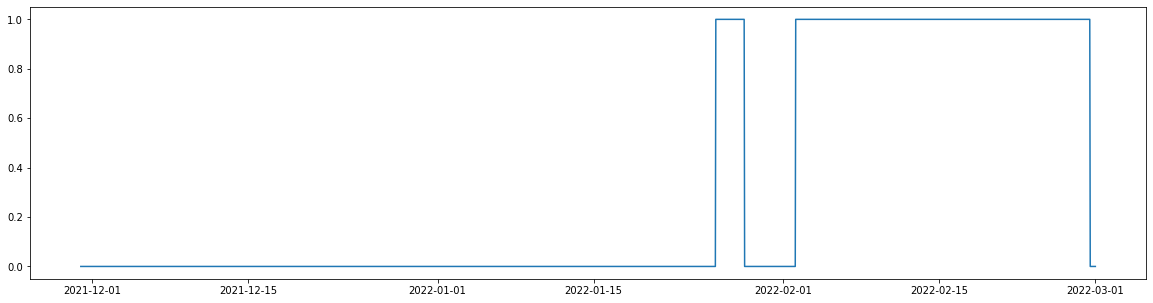

In [18]:
#print(temp_list[0])
cesare = temp_list[0]
plt.figure(figsize=(20,5))
plt.plot(cesare['Timestamp'], cesare['Fault'])

In [19]:
df = pd.concat(temp_list)